# Split Operator Evolution

Here we discuss some details about the split-operator evolution method.  The motivation is the evolution of a Schrödinger-like equation of the following form:

$$
  \I\hbar\partial_t \psi = \op{H}\cdot\psi = (\op{K} + \op{V}_t[\psi])\cdot\psi
$$

where the kinetic energy operator $\op{K}$ is diagonal in momentum space and the potential operator $\op{V}_t[\psi]$ is diagonal in position space but might depend non-linearly on time and/or the state itself.

The basic idea is to perform unitary evolution with

$$
  \psi(t+\delta) = e^{\op{H}_t\delta/\I\hbar}\psi(t)
$$

which will explicitly preserve the norm of the state.  In what follows to simplify the notation we set $\I\hbar = 1$.  Computing the matrix exponential is expensive since $\op{K}$ and $\op{V}$ do not commute and are not diagonal in the same space, so we expand this using one of the following forms for the Trotter decomposition

$$
  e^{\op{H}_t\delta} \approx e^{\op{K}\delta/2}e^{\op{V}\delta}e^{\op{K}\delta/2}
                     \approx e^{\op{V}\delta/2}e^{\op{K}\delta}e^{\op{V}\delta/2}.
$$

The idea is that since both $\op{K}$ and $\op{V}$ are diagonal in the appropriate space, the exponential is trivial to compute, and we can use the Fast Fourier Transfrom (FFT) between the steps to efficiently transfrom from one basis to the other.

## Error Analysis

We start with the simple case where $\op{V}$ is a constant.  In this case, if we could compute $e^{-\I\delta\op{H}}$ exactly, we would have exact evolution.  Expanding, we see that the split-operator approach accumulates an error $\order(\delta^3)$ per time-step and hence a total error $\order(\delta^2)$.

In [16]:
from IPython.display import display
import sympy
sympy.init_session(quiet=True)
from sympy.physics.quantum.operator import HermitianOperator, Operator
from sympy.physics.quantum.dagger import Dagger
d = var('delta', real=True)
K = Operator('K')
V = Operator('V')
H = K + V

IPython console for SymPy 0.7.7.dev (Python 2.7.10-64-bit) (ground types: python)


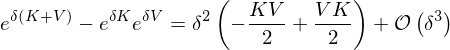

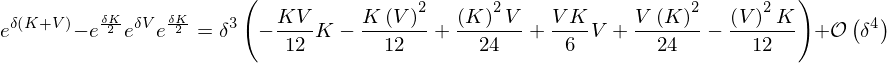

In [17]:
eH = exp(d*H)
eK = exp(d*K)
eK2 = exp(d*K/2)
eV = exp(d*V)
display(Eq(eH - eK*eV, series(eH - eK*eV, d, 0, 3)))
display(Eq(eH - eK2*eV*eK2, series(eH - eK2*eV*eK2, d, 0, 4)))

Here we see that the time-reversal invariant formula must be used to obtain a cubic order step.

### Complications

This error analysis presupposes that one can compute each of the factors to accuracy $\order(\delta^3)$ otherwise this error will dominate.  This faces two complications:

* $\op{V}_t$ depends on time.
* $\op{V}[\psi]$ depends on $\psi$.

In both these cases, one must expand $\op{V}(t+\delta) = \op{V} + \dot{\op{V}}\delta + \ddot{\op{V}}\delta^2/2 + \cdots$ and express the step in terms of $\dot{\psi}(t) = \op{V}(t)\cdot{\psi}(t)$ (considering here only the evolution with $\op{V}$).  This can be expanded:

$$
  \psi(t+\delta) = \psi + \delta \dot{\psi} + \frac{\delta^2}{2} \ddot{\psi} 
    + \frac{\delta^3}{3!} \dddot{\psi} + \order(\delta^4) 
  = \left(\op{1} + \delta \op{V} + \frac{\delta^2}{2}(\dot{\op{V}} + \op{V}^2)
  + \frac{\delta^3}{3!}(\ddot{\op{V}} + 2\dot{\op{V}}\op{V} + \op{V}\dot{\op{V}} + \op{V}^3) + \order(\delta^4)\right)\psi
$$

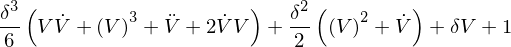

In [18]:
dV = Operator('\dot{V}')
ddV = Operator('\ddot{V}')
dddV = Operator('\dddot{V}')

def get_V(delta):
    return V + dV*delta + ddV*delta**2/2 + dddV*delta**3/6

def get_psi_psi(delta):
    """This is psi(t+delta)/psi(t) in matrix form"""
    return (1 + delta*V + delta**2/2*(dV + V*V) 
        + delta**3/6*(ddV + 2*dV*V + V*dV + V**3))

psi_psi = get_psi_psi(d)
psi_psi

Here we see that simply evolving with $\op{V}(t)$ for the whole step yields an error of $\order(\delta^2)$ unless $\dot{\op{V}} = 0$:

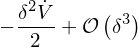

In [19]:
series(exp(d*V) - psi_psi, d, 0, 3)

One solution is to use the midpoint: $e^{\delta(V_t + V_{t+\delta})/2}$:

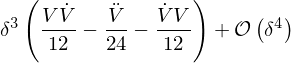

In [20]:
series(exp(d*get_V(d/2)) - psi_psi, d, 0, 4)

Performing a non-linear expansion in the dependence on $\mat{V}[\psi]$ is more challenging since expanding in variations requires additional index summations.

# Numerical Example

In [21]:
%pylab inline --no-import-all
from scipy.linalg import expm
from scipy.integrate import odeint

class Problem(object):
    def __init__(self, N=2, diagonal=False, nonlinear=True, timefactor=0.1, 
                 t0=0.0, T=0.1, Ntslim=12):
        self.shape = (N, N)
        self.nonlinear = nonlinear
        self.diagonal = diagonal
        self.timefactor = timefactor
        np.random.seed(1)
        self.K = np.random.random(self.shape) - 0.5
        self.V = np.random.random(self.shape) - 0.5
        self.psi0 = np.random.random(N) - 0.5
        self.t0 = t0
        self.T = T
        self.Nts = 2**np.arange(4, Ntslim)

    def get_V(self, psi, t):
        V = 1*self.V
        if self.nonlinear:
            V += np.diag(abs(psi)**2)
        if self.diagonal:
            V = np.diag(np.diag(V))
        V *= 1.0 + self.timefactor*np.cos(2*np.pi * t/(self.T-self.t0))
        return V

    def compute_dy(self, psi, t):
        return (self.K + self.get_V(psi=psi, t=t)).dot(psi)
        
    def exact(self, atol=1e-14, rtol=1e-16, mxstep=50000):
        dtype = self.K.dtype
        x0 = self.psi0.view(dtype=float)
        def f(x, t):
            return self.compute_dy(x.view(dtype=dtype), t).view(dtype=float)

        res = odeint(
            f, x0, [self.t0, self.T],
            atol=atol, rtol=rtol, mxstep=mxstep)[-1]

        return res.view(dtype=dtype)

    def get_errs(self, evolve):
        errs = []
        exact = self.exact()
        for Nt in self.Nts:
            psi = evolve(Nt, p=self)
            errs.append(abs(psi - exact).max())
        return np.asarray(errs)

def evolve_KVK1(Nt, p):
    """No good for non-linear functionals."""
    psi = 1*p.psi0
    t = 1*p.t0
    dt = p.T/Nt
    for N in xrange(Nt):
        psi = expm(0.5*dt * p.K).dot(psi)
        t += 0.5*dt
        psi = expm(dt*p.get_V(psi=psi, t=t)).dot(psi)
        t += 0.5*dt
        psi = expm(0.5*dt * p.K).dot(psi)
    assert np.allclose(t, p.T-p.t0)
    return psi

def evolve_VKV1(Nt, p):
    """No good for non-linear functionals."""
    psi = 1*p.psi0
    t = 1*p.t0
    dt = p.T/Nt
    for N in xrange(Nt):
        t += 0.25*dt
        psi = expm(0.5*dt*p.get_V(psi=psi, t=t)).dot(psi)
        t += 0.25*dt
        psi = expm(dt * p.K).dot(psi)
        t += 0.25*dt        
        psi = expm(0.5*dt*p.get_V(psi=psi, t=t)).dot(psi)
        t += 0.25*dt
    assert np.allclose(t, p.T-p.t0)
    return psi

def evolve_KVK2(Nt, p):
    """Faster version of KVK1."""
    psi = 1*p.psi0
    t = 1*p.t0
    dt = p.T/Nt
    for N in xrange(Nt):
        if N == 0:
            psi = expm(0.5*dt * p.K).dot(psi)
            t += 0.5*dt
        else:
            psi = expm(dt * p.K).dot(psi)
            t += dt
        
        psi = expm(dt*p.get_V(psi=psi, t=t)).dot(psi)

    psi = expm(0.5*dt * p.K).dot(psi)
    t += 0.5*dt
    assert np.allclose(t, p.T-p.t0)
    return psi

def evolve_G(Nt, p):
    """Gabriel's implementation"""
    psi = 1*p.psi0
    t = 1*p.t0
    dt = p.T/Nt
    for N in xrange(Nt):
        psi0 = psi.copy()
        
        psi = expm(0.5*dt*p.get_V(psi=psi, t=t)).dot(psi)
        psi = expm(dt * p.K).dot(psi)
        psi1 = expm(0.5*dt*p.get_V(psi=psi, t=t+dt)).dot(psi)
        psi1 = (psi1 + psi0)/2.0
        psi = psi0
        
        psi = expm(0.5*dt*p.get_V(psi=psi1, t=t)).dot(psi)
        psi = expm(dt * p.K).dot(psi)
        psi = expm(0.5*dt*p.get_V(psi=psi1, t=t+dt)).dot(psi)

        t += dt
    assert np.allclose(t, p.T-p.t0)
    return psi

def evolve_KVKM1(Nt, p):
    """Non-linear safe version of KVK1."""
    psi = 1*p.psi0
    t = 1*p.t0
    dt = p.T/Nt
    for N in xrange(Nt):
        if N == 0:
            psi = expm(0.5*dt * p.K).dot(psi)
            t += 0.5*dt
        else:
            psi = expm(dt * p.K).dot(psi)
            t += dt
            
        psi0 = psi.copy()
        psi = expm(dt*p.get_V(psi=psi, t=t)).dot(psi)
        psi1 = (psi + psi0)/2.0
        psi = expm(dt*p.get_V(psi=psi1, t=t)).dot(psi0)

    psi = expm(0.5*dt * p.K).dot(psi)
    t += 0.5*dt
    
    assert np.allclose(t, p.T-p.t0)
    return psi

def evolve_KVKM2(Nt, p):
    """This version subdivides the potential calculation to save
    memory, but does not perform very well."""
    psi = 1*p.psi0
    t = 1*p.t0
    dt = p.T/Nt
    NV = 2
    for N in xrange(Nt):
        if N == 0:
            psi = expm(0.5*dt * p.K).dot(psi)
            t += 0.5*dt
        else:
            psi = expm(dt * p.K).dot(psi)
            t += dt
        
        for _n in range(NV):
            psi = expm(dt/NV * p.get_V(psi=psi, t=t)).dot(psi)

    psi = expm(0.5*dt * p.K).dot(psi)
    t += 0.5*dt
    assert np.allclose(t, p.T-p.t0)
    return psi

def evolve_KVKM3(Nt, p):
    """This version uses a linear combination of the potentials rather 
    than of the states and evolves back in time by half a step."""
    psi = 1*p.psi0
    t = 1*p.t0
    dt = p.T/Nt
    for N in xrange(Nt):
        if N == 0:
            psi = expm(0.5*dt * p.K).dot(psi)
            t += 0.5*dt
        else:
            psi = expm(dt * p.K).dot(psi)
            t += dt
        
        V0 = p.get_V(psi=psi, t=t)
        psi = expm(dt*V0).dot(psi)
        V1 = p.get_V(psi=psi, t=t)
        psi = expm(0.5*dt * (V1 - V0)).dot(psi)

    psi = expm(0.5*dt * p.K).dot(psi)
    t += 0.5*dt
    
    assert np.allclose(t, p.T-p.t0)
    return psi

evolvers = [locals()[_f] for _f in list(locals())
            if _f.startswith('evolve_')]

good_evolvers = [evolve_G, evolve_KVKM1, evolve_KVKM3]

Populating the interactive namespace from numpy and matplotlib


First we test all the evolvers with a time-dependent but linear potential:

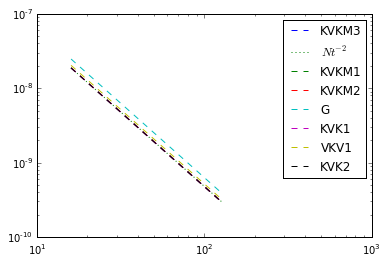

In [22]:
p = Problem(nonlinear=False, diagonal=False, timefactor=1.0, Ntslim=8)
for _n, evolve in enumerate(evolvers):
    label = evolve.func_code.co_name[7:]
    errs = p.get_errs(evolve)
    plt.loglog(p.Nts, errs, ls='--', ms='+', label=label)
    if _n == 0:
        plt.loglog(p.Nts, errs[0]*(1.0*p.Nts[0]/p.Nts)**2, 'g:', label=r"$Nt^{-2}$")
plt.legend(loc='best')

Some approaches fail if the function contains non-linear terms:

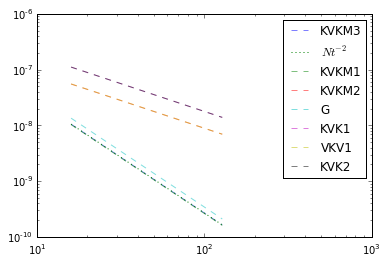

In [23]:
p = Problem(nonlinear=True, diagonal=False, Ntslim=8)
for _n, evolve in enumerate(evolvers):
    label = evolve.func_code.co_name[7:]
    errs = p.get_errs(evolve)
    plt.loglog(p.Nts, errs, ls='--', ms='+', label=label, alpha=0.5)
    if _n == 0:
        plt.loglog(p.Nts, errs[0]*(1.0*p.Nts[0]/p.Nts)**2, 'g:', label=r"$Nt^{-2}$")
plt.legend(loc='best')

Here are the good evolvers.

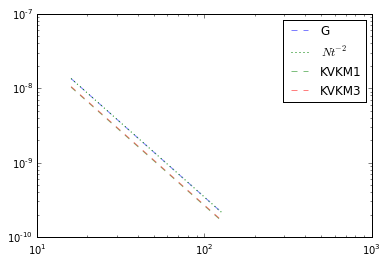

In [24]:
p = Problem(nonlinear=True, diagonal=False, Ntslim=8)
for _n, evolve in enumerate(good_evolvers):
    label = evolve.func_code.co_name[7:]
    errs = p.get_errs(evolve)
    plt.loglog(p.Nts, errs, ls='--', ms='+', label=label, alpha=0.5)
    if _n == 0:
        plt.loglog(p.Nts, errs[0]*(1.0*p.Nts[0]/p.Nts)**2, 'g:', label=r"$Nt^{-2}$")
plt.legend(loc='best')

## Unitary Evolution

Here we test the same evolvers with unitary evolution.

In [25]:
%pylab inline --no-import-all
from scipy.linalg import expm
from scipy.integrate import odeint

class ProblemUnitary(Problem):
    def __init__(self, N=2, diagonal=False, nonlinear=True, timefactor=0.1, 
                 t0=0.0, T=0.1, Ntslim=12, density_err=False):
        self.shape = (N, N)
        self.nonlinear = nonlinear
        self.diagonal = diagonal
        self.timefactor = timefactor
        np.random.seed(1)
        K = np.random.random(self.shape) - 0.5 + 1j*(np.random.random(self.shape) - 0.5)
        self.K = (K + K.conj().T)/1j
        V = np.random.random(self.shape) - 0.5 + 1j*(np.random.random(self.shape) - 0.5)
        self.V = (V + V.conj().T)/1j
        self.psi0 = np.random.random(N) - 0.5 + 1j*(np.random.random(N) - 0.5)
        self.t0 = t0
        self.T = T
        self.Nts = 2**np.arange(4, Ntslim)
        self.density_err = density_err

    def get_V(self, psi, t):
        V = 1*self.V
        if self.nonlinear:
            V += np.diag(abs(psi)**2)/1j
        if self.diagonal:
            V = np.diag(np.diag(V))
        V *= 1.0 + self.timefactor*np.cos(2*np.pi * t/(self.T-self.t0))
        return V
    
    def get_errs(self, evolve):
        errs = []
        exact = self.exact()
        for Nt in self.Nts:
            psi = evolve(Nt, p=self)
            if self.density_err:
                errs.append(abs((abs(psi)**2 - abs(exact)**2)).max())
            else:
                errs.append(abs(psi -exact).max())
                
        return np.asarray(errs)

Populating the interactive namespace from numpy and matplotlib


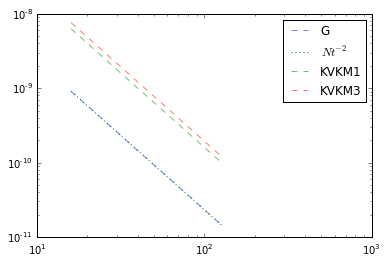

In [26]:
p = ProblemUnitary(nonlinear=True, diagonal=True, Ntslim=8, density_err=True)
offset = 1.2
for _n, evolve in enumerate(good_evolvers):
    label = evolve.func_code.co_name[7:]
    errs = p.get_errs(evolve)*offset**_n
    plt.loglog(p.Nts, errs, ls='--', ms='+', label=label, alpha=0.5)
    if _n == 0:
        plt.loglog(p.Nts, errs[0]*(1.0*p.Nts[0]/p.Nts)**2, 'g:', label=r"$Nt^{-2}$")
plt.legend(loc='best')

Note that Gabirel's approach does gain an order of magnitude improvement over the others for diagonal problems, but not for the generic case.

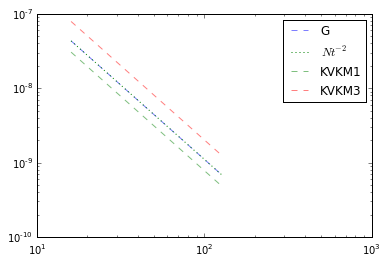

In [27]:
p = ProblemUnitary(nonlinear=True, diagonal=False, Ntslim=8, density_err=True)
offset = 1.2
for _n, evolve in enumerate(good_evolvers):
    label = evolve.func_code.co_name[7:]
    errs = p.get_errs(evolve)*offset**_n
    plt.loglog(p.Nts, errs, ls='--', ms='+', label=label, alpha=0.5)
    if _n == 0:
        plt.loglog(p.Nts, errs[0]*(1.0*p.Nts[0]/p.Nts)**2, 'g:', label=r"$Nt^{-2}$")
plt.legend(loc='best')

 Also, this gain is only seen in the density differences, not in the wavefunction differences:

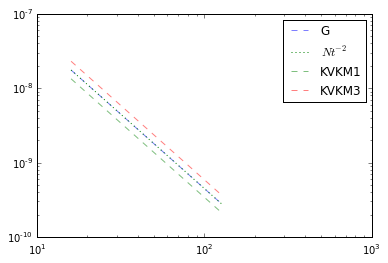

In [28]:
p = ProblemUnitary(nonlinear=True, diagonal=True, Ntslim=8, density_err=False)
offset = 1.2
for _n, evolve in enumerate(good_evolvers):
    label = evolve.func_code.co_name[7:]
    errs = p.get_errs(evolve)*offset**_n
    plt.loglog(p.Nts, errs, ls='--', ms='+', label=label, alpha=0.5)
    if _n == 0:
        plt.loglog(p.Nts, errs[0]*(1.0*p.Nts[0]/p.Nts)**2, 'g:', label=r"$Nt^{-2}$")
plt.legend(loc='best')

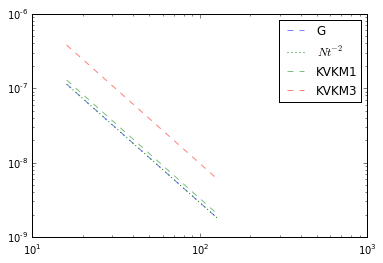

In [29]:
p = ProblemUnitary(nonlinear=True, diagonal=False, Ntslim=8, density_err=False)
offset = 1.3
for _n, evolve in enumerate(good_evolvers):
    label = evolve.func_code.co_name[7:]
    errs = p.get_errs(evolve)*offset**_n
    plt.loglog(p.Nts, errs, ls='--', ms='+', label=label, alpha=0.5)
    if _n == 0:
        plt.loglog(p.Nts, errs[0]*(1.0*p.Nts[0]/p.Nts)**2, 'g:', label=r"$Nt^{-2}$")
plt.legend(loc='best')

# Conclusion

We conclude that performing the step as follows will preserve the convergence in the presence of non-linear and off-diagonal terms:

$$
  e^{\mat{H}\delta} \approx e^{\mat{K}\delta/2}e^{V\delta}e^{\mat{K}\delta/2}
$$

where we perform the step $e^{\mat{V}\delta}$ as follows:

$$
   \psi_1 = e^{\mat{V}[\psi_0]\delta}\psi_0, \qquad
   \psi = e^{\mat{V}\left[\tfrac{\psi_0+\psi_1}{2}\right]\delta}\psi_0.
$$

All potentials are evaluated at $t$ in the midpoint of the interval.

Some problems do not need the corrective step (i.e. the linear Schrödinger equation), so we should provide a way to turn it off (probably in the evolver).  Finally, we allow for a specialization where the non-linear portion of the potential can be stored more efficiently than an extra copy of the whole state.  In this latter case.  This is the case with fermionic DFTs for example where the "state" consists of thousands of single-particle states while the potential is a single function.